# Reddit r/cryptocurrency sentiment analysis using Naive Bayes Classifier.

#### Importing all the necessary libraries

In [2]:
import re
import time
import nltk
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

#### Creating Pandas dataframe

In [2]:
df = pd.read_csv('dataset.csv', encoding = 'Latin-1', names=('Sentiment','ID','Date','Flag','Username','Text'))

In [3]:
df.head()

,Sentiment,ID,Date,Flag,Username,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


This dataset has a total of six columns. The sentiment column denotes the overall sentiment of the post, 0 for negative and 4 for positive. 

#### Seperating positive and negative texts

In [4]:
positive_texts = []
negative_texts = []
start = time.time()
for index, row in df.iterrows():
    if row['Sentiment'] == 0:
        negative_texts.append(row['Text'])
    elif row['Sentiment'] == 4:
        positive_texts.append(row['Text'])
end = time.time()
print('Texts seperated between positive and negative.')
print(f'There are all total {len(positive_texts) + len(negative_texts)}')
print(f"Total time taken: {end - start}")

Texts seperated between positive and negative.
There are all total 1600000
Total time taken: 56.66616678237915


The total number of texts in this dataset are 1.6 million. Hence, it takes a lot of time to compute the data. The numbers need to be reduced to compute the data without taking a lot of time.

#### Reducing the number of positive and negative texts

In [5]:
positive_texts = positive_texts[:len(positive_texts)//2]
negative_texts = negative_texts[:len(negative_texts)//2]

#### Checking the number of positive and negative texts

In [6]:
print(f"The total number of positive texts are: {len(positive_texts)}")
print(f"The total number of negative texts are: {len(negative_texts)}")

The total number of positive texts are: 400000
The total number of negative texts are: 400000


It can be seen from the dataframe above that many texts have unnecessary symbols and hyperlinks. These should be thoroughlly cleaned to get rid of any noise in the data.

#### Creating a function that cleans the documents

In [3]:

nltk.download('stopwords')
stopwords_english = stopwords.words('english')


stemmer = PorterStemmer()


punctuations = string.punctuation


tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def process_text(text):
    
    final_texts = []
    clean_texts = []
    
    
    text = re.sub(r'^RT[\s]+', '', text)

    #hypls
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

   #
    text = re.sub(r'#', '', text)
    
   
    text_tokens = tokenizer.tokenize(text)
    
   
    for word in text_tokens:
        if (word not in stopwords_english and word not in punctuations):
            clean_texts.append(word)
    
   
    for word in clean_texts:
        stem_word = stemmer.stem(word)
        final_texts.append(stem_word)
        
    return final_texts

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
print(process_text(positive_texts[100]))

['determin', 'get', 'back', 'basebal', '5', 'year', 'sinc', "i'v", 'realli', 'watch', 'sport', 'anyon', 'interest', 'go', 'game']


The code above gets rid of all the hashtags, RTs, Hyperlinks, Punctuations, and Stopwords from the tweets. Afterwards, it tokenizes the tweets, and converts individual tokens into stems.

#### Creating a function that generates a frequency dictionary

In [9]:
def create_frequency_dict(texts, sentiments):
    
    frequency_dict = {}

    for text, sentiment in zip(texts, sentiments):
        for word in process_text(text):
            pair = (word, sentiment)
            
            if pair in frequency_dict:
                frequency_dict[pair] += 1
            else:
                frequency_dict[pair] = frequency_dict.get(pair, 1)
    
    return frequency_dict

#### Initializing the training data

In [10]:
train_x = positive_texts + negative_texts
train_y = np.append(np.ones(len(positive_texts)), np.zeros(len(negative_texts)))

In [11]:
print(len(train_x))
print(train_y.shape[0])

800000
800000


#### Creating the frequency dictionary

In [12]:
freq_dict = create_frequency_dict(train_x, train_y)
print("Frequency dictionary created.")

Frequency dictionary created.


#### Training the Naive Bayes algorithm

In [13]:
def naive_bayes(frequency_dictionary, train_x, train_y):

    word_likelihood_log = {}
    prior_probability_log = 0
    
    # Calculating the number of unique words in the frequency dictionary.
    unique_words = set([pair[0] for pair in frequency_dictionary.keys()])
    V = len(unique_words)
    
    # Calculating the number of positive and negative texts.
    N_pos = 0
    N_neg = 0
    for pair in frequency_dictionary.keys():  
        if pair[1] > 0:
            N_pos += frequency_dictionary[(pair)]
        else:
            N_neg += frequency_dictionary[(pair)]
            
            
    # Calculating total number of documents
    D = train_y.shape[0]
    
    # Calculating the number of positive documents
    D_pos = sum(train_y)
    
    # Calculating the number of negative documents
    D_neg = D - D_pos
    
    # Calculate the prior probability log
    prior_probability_log = np.log(D_pos) - np.log(D_neg)
    
    for word in unique_words:
        
        # Computing the positive and negative frequency of the words
        freq_pos = frequency_dictionary.get((word, 1.0), 0)
        freq_neg = frequency_dictionary.get((word, 0.0), 0)
        
        # Calculating the probability of the word being positive or negative
        p_w_pos = (freq_pos + 1) / (N_pos + V) 
        p_w_neg = (freq_neg + 1) / (N_neg + V) 
        
        # Calculating the log likelihood of the word
        word_likelihood_log[word] = np.log(p_w_pos / p_w_neg)
        
    return prior_probability_log, word_likelihood_log

#### Generating the prior probability log, and the word likelihood log

In [14]:
prior_probability, word_likelihood_dict = naive_bayes(freq_dict, train_x, train_y)
print(prior_probability)
print(len(word_likelihood_dict))

0.0
171843


#### Creating the prediction algorithm

In [15]:
def predict_sentiment(text, prior_probability, word_likelihood_dict):

    #Processing the tweets
    words = process_text(text)

    #Initial Probability
    probability = 0

    #Adding the log of prior probability
    probability += prior_probability

    for word in words:
        if word in word_likelihood_dict:
            probability += word_likelihood_dict[word]

    return probability

#### Testing the prediction algorithm with some dummy data

In [16]:
for tweet in ['Things are declining','I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great', 'bad bad bad bad']:
    p = predict_sentiment(tweet, prior_probability, word_likelihood_dict)
    print(f'{tweet} -> {p:.2f}')

Things are declining -> -1.48
I am happy -> 1.36
I am bad -> -1.28
this movie should have been great. -> 1.75
great -> 1.18
great great -> 2.36
great great great -> 3.54
great great great great -> 4.72
bad bad bad bad -> -5.13


# Initializing the Reddit api to fetch data

#### Importing the required libraries

In [17]:
import praw

#### Authenticating with the api

In [18]:
CLIENT_SECRET = 'qb_WDV_3cYQP7My2ZfJhU7Slf4YIMg'
CLIENT_ID = 'L-JwG93adjPhPKBiqP5sfw'
PASSWORD = 'nimbupani123'
USERNAME = 'apifor'
USER_AGENT = 'sentiment by u/apifor'

reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    password=PASSWORD,
    user_agent="testscript by u/fakebot3",
    username=USERNAME,
)

#### Gathering the newest 1000 data from r/cryptocurrency

In [19]:
subreddit = reddit.subreddit('cryptocurrency')
recent_submissions = []
for submissions in subreddit.new(limit = None):
  recent_submissions.append(submissions.title)

#### Seperating the posts according to different cryptocurrencies

In [20]:
ethereum_posts = []
bitcoin_posts = []
for submission in recent_submissions:
    cleaned_text = process_text(submission)
    if 'eth' in cleaned_text or 'ethereum' in cleaned_text or 'ether' in cleaned_text:
        ethereum_posts.append(submission)
    elif 'btc' in cleaned_text or 'bitcoin' in cleaned_text:
        bitcoin_posts.append(submission)

## Calculating the positive to negative sentiment ratio of bitcoin and ethereum

**Bitcoin**

In [21]:
btc_pos = 0
btc_neg = 0
for post in bitcoin_posts:
    sentiment = predict_sentiment(post, prior_probability, word_likelihood_dict)
    if sentiment > 0:
        btc_pos += 1
    else:
        btc_neg += 1
btc_pos_neg_ratio = btc_pos / btc_neg
print(btc_pos_neg_ratio)

2.2051282051282053


**Ethereum**

In [22]:
eth_pos = 0
eth_neg = 0
for post in ethereum_posts:
    sentiment = predict_sentiment(post, prior_probability, word_likelihood_dict)
    if sentiment > 0:
        eth_pos += 1
    else:
        eth_neg += 1
eth_pos_neg_ratio = eth_pos / eth_neg
print(eth_pos_neg_ratio)

1.7142857142857142


#### Visualizing the positive to negative ratio of bitcoin and ethereum

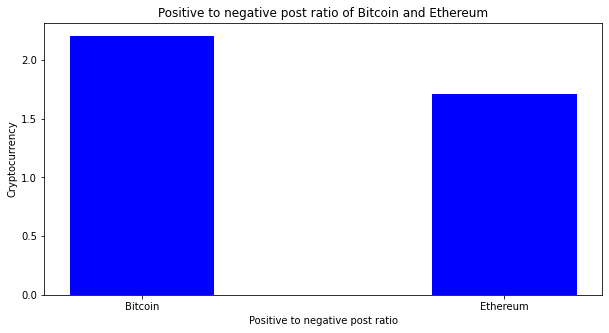

In [23]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['Bitcoin', 'Ethereum'], [btc_pos_neg_ratio, eth_pos_neg_ratio], color ='blue',
        width = 0.4)
 
plt.xlabel("Positive to negative post ratio")
plt.ylabel("Cryptocurrency")
plt.title("Positive to negative post ratio of Bitcoin and Ethereum")
plt.show()
plt.show()

**Conclusion:** The bar above depicts that the community r/cryptocurrency has a more positive outlook for bitcoin than ethereum. Therefore, bitcoin looks like a better investment.

## Generating wordcloud

In [24]:
#installing wordcloud
!pip install wordcloud

#### Cleaning the submissions to remove stopwords and irregularities.

In [25]:
wordcloud_list = []
for post in recent_submissions:
    cleaned_posts = process_text(post)
    for word in cleaned_posts:
        wordcloud_list.append(word)

#### Generating the wordcloud 

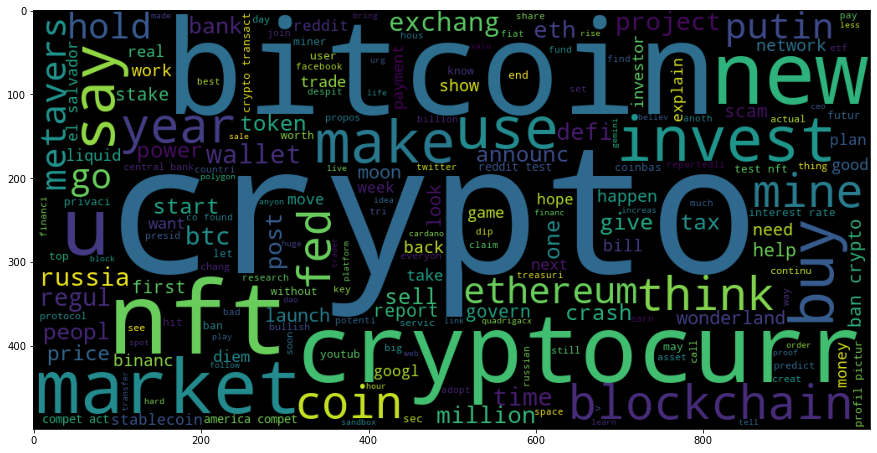

In [26]:
from wordcloud import WordCloud

cloud_string =(" ").join(wordcloud_list)
wordcloud = WordCloud(width = 1000, height = 500).generate(cloud_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()


**Conclusion:** Besides the word crypto, bitcoin seems to be the most discussed word. Therefore, people seem more interested in bitcoin compared to other cryptocurrencies.

## Calculating the overall market sentiment of r/cryptocurrency

In [27]:
polarity_scores = []
polarity_dict = {'Positive': 0, 'Negative': 0}
for post in recent_submissions:
    sentiment = predict_sentiment(post, prior_probability, word_likelihood_dict)
    if sentiment < 0:
        polarity_scores.append(0)
        polarity_dict['Negative'] += 1
    else:
        polarity_scores.append(1)
        polarity_dict['Positive'] += 1

In [28]:
post_polarity = list(zip(recent_submissions, polarity_scores))

In [29]:
crypto_dataframe = pd.DataFrame(post_polarity, columns=['Post', 'Sentiment'])

In [30]:
crypto_dataframe.head()

,Post,Sentiment
0,⁠Belgian MP becomes first European politician ...,1
1,Former Chancellor Says It Is “shocking” That T...,1
2,Apple shares skyrocket after metaverse announc...,1
3,El Salvador’s president is making choice on be...,1
4,Trezor to implement KYC. The user information ...,1


#### Bar Chart depicting the total number of positive vs negative posts

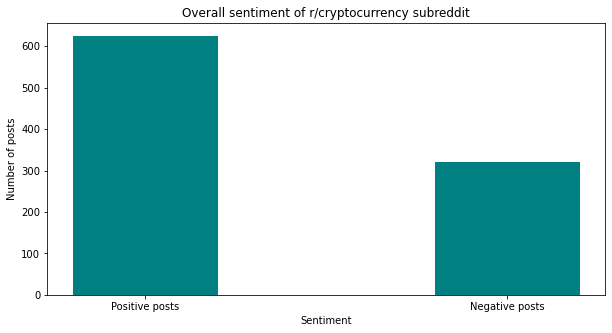

In [31]:
len_pos = polarity_dict['Positive']
len_neg = polarity_dict['Negative']

fig = plt.figure(figsize = (10, 5))
plt.bar(['Positive posts', 'Negative posts'], [len_pos, len_neg], color ='teal',
        width = 0.4)
 
plt.xlabel("Sentiment")
plt.ylabel("Number of posts")
plt.title("Overall sentiment of r/cryptocurrency subreddit")
plt.show()
plt.show()

**Conclusion**: The bar chart shows a larger number of positive tweets than negative tweets. Which means, the outlook of the subreddit r/cryptocurrency is positive overall.

#### Pie chart depicting the total number of positive vs negative posts

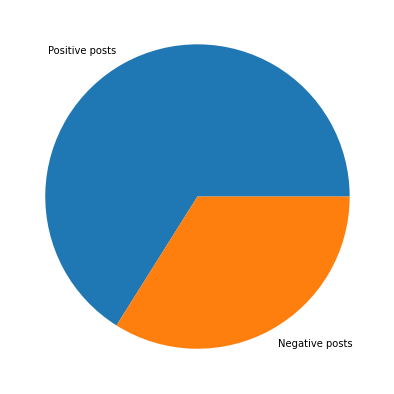

In [32]:
len_pos = polarity_dict['Positive']
len_neg = polarity_dict['Negative']

sentiments = ['Positive posts', 'Negative posts']
polarity = [len_pos, len_neg]
 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(polarity, labels = sentiments)
 
# show plot
plt.show()

# Conclusion

According to the bar and pie chart depicting the current overall outlook of the community r/cryptocurrency, the bar chart showing the positive to negative ratio of bitcoin and ethereum, and the word cloud, the following things could be concluded:

1. The overall outlook of the community r/cryptocurrency is positive as a whole.
2. Bitcoin is the most discussed cryptocurrency.
3. The positive to negative sentiment ratio is high for bitcoin, compared to ethereum.

Therefore, although the prices of cryptocurrencies have been declining, people have positive outlook regarding bitcoin. Which means, bitcoin look like a safe investment.